In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from sklearn.decomposition import PCA, KernelPCA

In [18]:
from hsr4hci.utils.config import load_config
from hsr4hci.utils.data import load_data
from hsr4hci.utils.fits import save_fits
from hsr4hci.utils.adi_tools import derotate_frames
from hsr4hci.utils.evaluation import compute_figures_of_merit
from hsr4hci.utils.forward_modeling import get_signal_stack

## Start the experiment

In [19]:
# Beta Pic
experiment_dir = "../experiments/tests_with_masks/"
config = load_config(os.path.join(experiment_dir, 'config.json'))

stack, parang, psf_template = load_data(config["dataset"])
psf_template = psf_template[80:-80,80:-80 ]
n_components = 50
comp_update=5

planet_pos_in_res = (49, 26)
fake_planet_pos_in_res = (33, 75)

In [16]:
# HR8799
experiment_dir = "../experiments/tests_with_masks/"
config = load_config(os.path.join(experiment_dir, 'config.json'))
config["dataset"]["file_path"] = "../../../30_data/HR8799/stacked_50.hdf"
config["dataset"]["frame_size"] = [149, 149]

stack, parang, psf_template = load_data(config["dataset"])
parang = np.concatenate([parang[:280], parang[495:]])
stack = np.concatenate([stack[:280], stack[495:]])
stack = stack[:, 30:-30, 30:-30]
n_components = 5
comp_update=1

#planet_pos_in_res = (58, 41)
#fake_planet_pos_in_res = (58, 41)

In [20]:
stack -= np.median(stack, axis=0)
print(stack.shape)
print(psf_template.shape)

(594, 81, 81)
(25, 25)


## Add a fake planet

In [21]:
fake_signal = get_signal_stack((15, 15),
                              frame_size=(stack.shape[1],
                                          stack.shape[2]),
                              parang=parang,
                              psf_cropped=psf_template)[0]
fake_signal /= np.max(fake_signal)
fake_signal *= 20

In [22]:
stack += fake_signal

## Add grid pattern

In [23]:
pattern = np.ones((stack.shape[1], stack.shape[2]))
length = stack.shape[1]

idx = [i for i in range(stack.shape[1]) if i%10==0 or i%10==1 or i%10==2]

pattern[idx] = 0
pattern[:, idx] = 0

pattern_stack = np.array([pattern for i in range(stack.shape[0])])
pattern_stack = derotate_frames(pattern_stack, -parang)

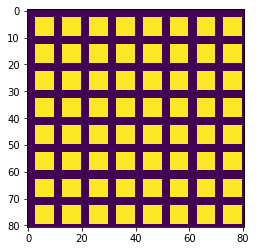

In [24]:
plt.imshow(pattern)

In [25]:
stack += pattern_stack * 10

## Fit PCA one step

In [26]:
def run_one_step_fit(input_stack, 
                     last_residual_positive_part,
                     n_components,
                     delta_residual = False):
    # 1.) Create the signal stack from the last residual and subtract it
    signal = deepcopy(last_residual_positive_part)
    signal_stack = np.array([signal for i in range(input_stack.shape[0])])
    signal_stack = derotate_frames(signal_stack, -parang)
    new_stack = input_stack - signal_stack
    
    # 2.) Build the noise model and subtract it
    pca_model = PCA(n_components=n_components)
    #pca_model = KernelPCA(n_components=n_components,
    #                      kernel="rbf", 
    #                      fit_inverse_transform=True)
    pca_model.fit(new_stack.reshape(new_stack.shape[0], -1))
    noise_estimate = pca_model.inverse_transform(
        pca_model.transform(new_stack.reshape(
            new_stack.shape[0], -1))).reshape(*new_stack.shape)
    
    residual = new_stack - noise_estimate
    
    # 3.) Detrotate and average the resigual or delta residual
    residual = derotate_frames(residual, parang)
    resiudal_delta = np.mean(residual, axis=0)
    
    # 4.) a delta residual should only correct small mistakes. Its mean should be around 0.
    # Note if we don't do this there is a risk that we continously add or subtract flux all over the frame
    if delta_residual:
        resiudal_delta -= np.mean(resiudal_delta)
        
    resiudal_frame = resiudal_delta + last_residual_positive_part
    
    return resiudal_frame, resiudal_delta

In [27]:
last_residual = np.zeros((stack.shape[1], stack.shape[2]))

residuals = []
delta_residuals = []
for i in tqdm(range(40)):
    if i%10==9:
        n_components += comp_update
    last_residual, delta_res = run_one_step_fit(input_stack=stack,
                                     last_residual_positive_part=last_residual,
                                     n_components = n_components,
                                     delta_residual= not(i==0))
    residuals.append(deepcopy(last_residual))
    delta_residuals.append(deepcopy(delta_res))
    last_residual[last_residual < 0] = 0

100%|██████████| 40/40 [01:16<00:00,  1.91s/it]


In [18]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_beta_pic.fits")
save_fits(delta_residuals, "/Users/markusbonse/Desktop/residuals_beta_pic_delta.fits")

In [27]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_hr8799.fits")
save_fits(delta_residuals, "/Users/markusbonse/Desktop/residuals_hr8799_delta.fits")

In [28]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_beta_pic_grid.fits")

## Evaluate signal and SNR

In [10]:
snr = []
signal = []
for tmp_residual in tqdm(residuals):
    res = compute_figures_of_merit(tmp_residual,
                                   position=planet_pos_in_res,
                                   aperture_size=2,
                                   ignore_neighbors=True,
                                   optimize="signal")
    snr.append(res["snr"])

100%|██████████| 80/80 [02:56<00:00,  2.21s/it]


Text(0.5, 1.0, 'SNR vs. iterations')

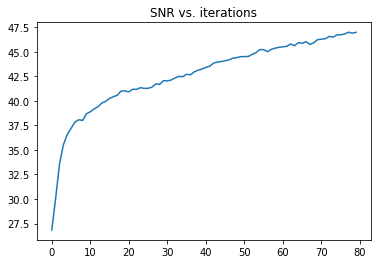

In [11]:
plt.plot(snr)
plt.title("SNR vs. iterations")

In [ ]:
plt.plot(signal)
plt.title("real planet signal vs. iterations")

In [12]:
snr = []
signal = []
for tmp_residual in tqdm(residuals):
    res = compute_figures_of_merit(tmp_residual,
                                   position=fake_planet_pos_in_res,
                                   aperture_size=2,
                                   ignore_neighbors=True,
                                   optimize="signal")
    snr.append(res["snr"])
    signal.append(res["signal"])

 35%|███▌      | 28/80 [02:24<04:28,  5.16s/it]

KeyboardInterrupt: 

In [ ]:
res_target = compute_figures_of_merit(fake_signal[0],
                                      position=(15, 15),
                                      aperture_size=2,
                                      ignore_neighbors=True,
                                      optimize="signal")["signal"]

In [ ]:
plt.plot(snr)
plt.title("SNR vs. iterations")

In [ ]:
plt.plot(signal)
plt.hlines(res_target, 0, len(signal)-1)
plt.title("fake signal vs. iterations")